# Experiment 1: Matrix Factorization with No Content Features

**Assumptions:** there are no tail users, validated because the IQR for interactions per used is 52, and only 3 users have less than 52 interactions.

**Models:** Alternating Least Squares (ALS), Singular Value Decomposition (SVD) and Bayesian Personalized Ranking (BPR)

**Evaluation:** _P@10, R@10, NDCG@10_

**Relevance Labels:** binary, if user interacted with item

## Interaction Matrix with Binary Labels

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
interactions = pd.read_csv("KGRec-dataset/KGRec-music/implicit_lf_dataset.csv", sep="\t", header=None)
interactions.columns = ["user_id", "item_id", "interaction"]

In [3]:
users = interactions["user_id"].unique()
items = interactions["item_id"].unique()

In [4]:
print("Number of users: ", len(users))
print("Number of items: ", len(items))
print("Number of interactions: ", len(interactions))

Number of users:  5199
Number of items:  8640
Number of interactions:  751531


In [5]:
def get_user_interactions(user_id):
    user_interactions =  interactions[interactions["user_id"] == user_id]["item_id"].values
    sparse_vector = [0] * len(items)
    for item in user_interactions:
        sparse_vector[item-1] = 1
    return np.array(sparse_vector)

In [6]:
def get_user_interactions_dense(user_id):
    user_interactions =  interactions[interactions["user_id"] == user_id]["item_id"].values
    return user_interactions

In [7]:
interactions[interactions["user_id"]==7596]

,user_id,item_id,interaction
102166,7596,130,1
102167,7596,4228,1
102168,7596,3326,1
102169,7596,4472,1
102170,7596,5478,1
...,...,...,...
102247,7596,1365,1
102248,7596,3192,1
102249,7596,1688,1
102250,7596,687,1


In [8]:
from scipy.sparse import csc_array

In [9]:
mapping = {user_id: i for i, user_id in enumerate(users)}

In [10]:
interactions_matrix = csc_array([get_user_interactions(user) for user in tqdm(users)], shape=(len(users), len(items)))

100%|██████████| 5199/5199 [00:04<00:00, 1069.10it/s]


## Singular Value Decomposition (SVD)

In [11]:
from sklearn.decomposition import TruncatedSVD

In [12]:
from usearch.index import Index
import ir_measures
from ir_measures import *

In [116]:
def evaluate_model(n_components, n_iter, k=10):
    svd = TruncatedSVD(n_components=n_components, n_iter=n_iter, random_state=42)
    svd.fit(interactions_matrix)

    user_vectors = svd.transform(interactions_matrix)
    item_vectors = svd.components_.T

    index = Index(ndim=n_components, metric='dot')
    index.add(keys = range(len(item_vectors)), vectors = item_vectors)

    qrels = interactions.rename(columns={'user_id': 'query_id', 'item_id': 'doc_id', 'interaction': 'relevance'})
    qrels["doc_id"] = qrels["doc_id"].astype(str)
    qrels["query_id"] = qrels["query_id"].astype(str)
    
    runs = []

    for user in users:
        matches = [int(item[0]) for item in index.search(user_vectors[mapping[user]], count=k, exact=True).to_list()]
        hits = get_user_interactions_dense(user).tolist()
        run = [ir_measures.ScoredDoc(query_id=str(user), doc_id=str(item), score=1.0) for item in matches if item in hits]
        runs.extend(run)

    evaluator = ir_measures.evaluator([P@10, R@10, nDCG@10], qrels)
    eval_res = evaluator.calc_aggregate(runs)
    eval_res["n_components"] = n_components
    eval_res["n_iter"] = n_iter
    return eval_res

In [117]:
eval_scores = []
for n_components in tqdm([10, 20, 50, 100]):
    for n_iter in [5, 10, 20, 50, 100]:
        eval_res = evaluate_model(n_components, n_iter, 10)
        eval_scores.append(eval_res)

100%|██████████| 4/4 [02:33<00:00, 38.42s/it]


In [118]:
eval_scores_df = pd.DataFrame(eval_scores)
eval_scores_df.columns = ["P@10", "R@10", "nDCG@10", "n_components", "n_iter"]

In [119]:
eval_scores_df.groupby(["n_components", "n_iter"]).max()

P@10      R@10   nDCG@10
n_components n_iter                              
10           5       0.001809  0.025909  0.055304
             10      0.001820  0.026082  0.055622
             20      0.001822  0.026082  0.055622
             50      0.001822  0.026082  0.055622
             100     0.001822  0.026082  0.055622
20           5       0.001601  0.022793  0.048695
             10      0.001620  0.023120  0.049284
             20      0.001617  0.023062  0.049157
             50      0.001617  0.023062  0.049157
             100     0.001617  0.023062  0.049157
50           5       0.001488  0.021273  0.045403
             10      0.001473  0.021100  0.045058
             20      0.001474  0.021081  0.045016
             50      0.001476  0.021100  0.045074
             100     0.001476  0.021100  0.045074
100          5       0.001470  0.020812  0.044497
             10      0.001484  0.021043  0.044974
             20      0.001505  0.021293  0.045430
             50      0.001489  0.021119  0.045102
             100     0.001495  0.021216  0.045277

<Axes: xlabel='n_components'>

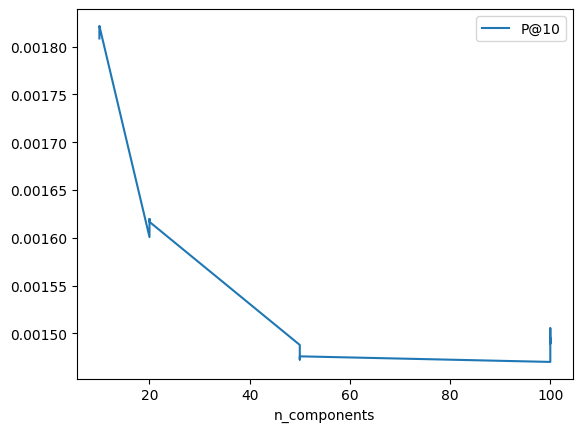

In [120]:
eval_scores_df.plot(x="n_components", y="P@10")

<Axes: xlabel='n_components'>

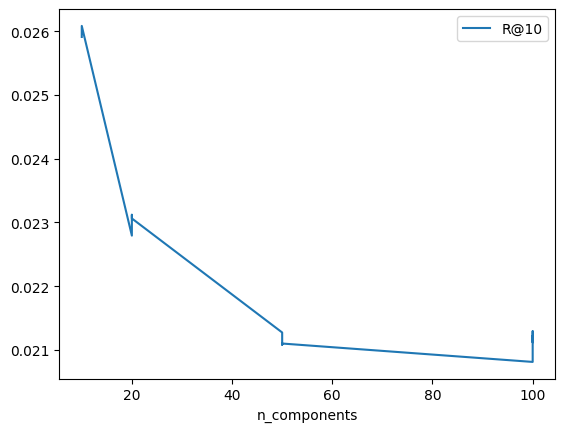

In [121]:
eval_scores_df.plot(x="n_components", y="R@10")

<Axes: xlabel='n_components'>

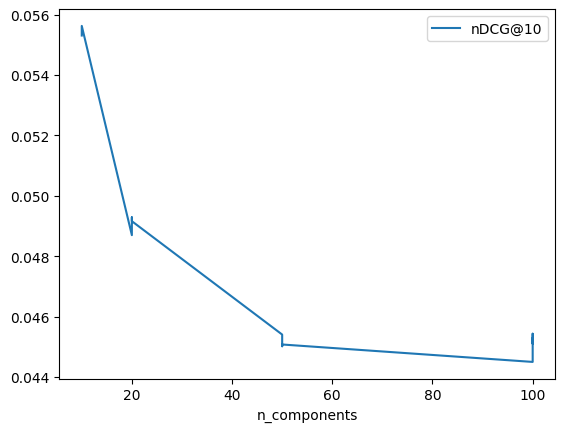

In [122]:
eval_scores_df.plot(x="n_components", y="nDCG@10")

## Interactions Matrix with TF-IDF Weights

In [68]:
def tfidf_score(t, d, N):
    """
    t = an item in the dataset
    d = a user's interactions (get_user_interactions_dense(user).tolist())
    N = total number of users 
    df = number of users that interacted with the item
    """
    if t not in d:
        return 0
    df = interactions[interactions["item_id"]==t]["user_id"].nunique()
    tf = d.count(t) / len(d)
    idf = np.log(N / df)
    return tf * idf

In [64]:
def get_user_interactions_tfidf(user_id):
    user_interactions =  interactions[interactions["user_id"] == user_id]["item_id"].values
    sparse_vector = [0] * len(items)
    for item in user_interactions:
        sparse_vector[item-1] = tfidf_score(item, get_user_interactions_dense(user_id).tolist(), len(users))
    return np.array(sparse_vector)

In [96]:
# TODO: this is horribly unoptimized, deal with it.
tfidf_interaction_matrix = csc_array([get_user_interactions_tfidf(user) for user in tqdm(users)], shape=(len(users), len(items)))

100%|██████████| 5199/5199 [16:06<00:00,  5.38it/s]


In [109]:
def evaluate_model(n_components, n_iter, k=10):
    svd = TruncatedSVD(n_components=n_components, n_iter=n_iter, random_state=42)
    svd.fit(tfidf_interaction_matrix)

    user_vectors = svd.transform(tfidf_interaction_matrix)
    item_vectors = svd.components_.T

    index = Index(ndim=n_components, metric='dot')
    index.add(keys = range(len(item_vectors)), vectors = item_vectors)

    qrels = interactions.rename(columns={'user_id': 'query_id', 'item_id': 'doc_id', 'interaction': 'relevance'})
    qrels["doc_id"] = qrels["doc_id"].astype(str)
    qrels["query_id"] = qrels["query_id"].astype(str)
    
    runs = []

    for user in users:
        matches = [int(item[0]) for item in index.search(user_vectors[mapping[user]], count=k, exact=True).to_list()]
        hits = get_user_interactions_dense(user).tolist()
        run = [ir_measures.ScoredDoc(query_id=str(user), doc_id=str(item), score=1.0) for item in matches if item in hits]
        runs.extend(run)

    evaluator = ir_measures.evaluator([P@10, R@10, nDCG@10], qrels)
    eval_res = evaluator.calc_aggregate(runs)
    eval_res["n_components"] = n_components
    eval_res["n_iter"] = n_iter
    return eval_res

In [110]:
eval_scores = []
for n_components in tqdm([10, 20, 50, 100]):
    for n_iter in [5, 10, 20, 50, 100]:
        eval_res = evaluate_model(n_components, n_iter, 10)
        eval_scores.append(eval_res)

100%|██████████| 4/4 [02:38<00:00, 39.50s/it]


In [111]:
eval_scores_df = pd.DataFrame(eval_scores)
eval_scores_df.columns = ["P@10", "R@10", "nDCG@10", "n_components", "n_iter"]

In [112]:
eval_scores_df.groupby(["n_components", "n_iter"]).max()

P@10      R@10   nDCG@10
n_components n_iter                              
10           5       0.001397  0.020119  0.042900
             10      0.001401  0.020119  0.042916
             20      0.001400  0.020119  0.042916
             50      0.001400  0.020119  0.042916
             100     0.001400  0.020119  0.042916
20           5       0.001265  0.017946  0.038262
             10      0.001352  0.019369  0.041296
             20      0.001333  0.019138  0.040814
             50      0.001330  0.019100  0.040750
             100     0.001330  0.019100  0.040750
50           5       0.001313  0.018965  0.040557
             10      0.001290  0.018600  0.039758
             20      0.001306  0.018831  0.040167
             50      0.001312  0.018965  0.040463
             100     0.001309  0.018927  0.040379
100          5       0.001291  0.018580  0.039815
             10      0.001318  0.018869  0.040382
             20      0.001327  0.018965  0.040541
             50      0.001328  0.019023  0.040689
             100     0.001328  0.019023  0.040674

<Axes: xlabel='n_components'>

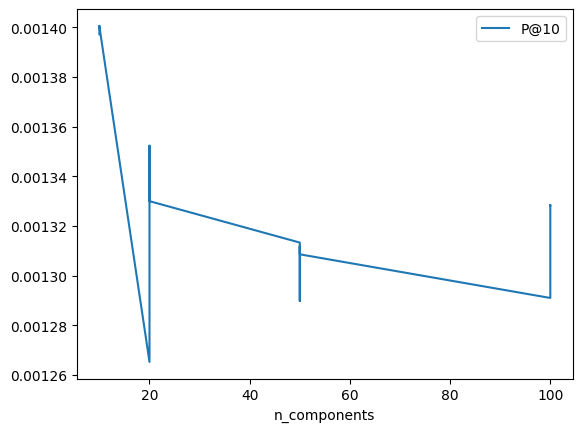

In [113]:
eval_scores_df.plot(x="n_components", y="P@10")

<Axes: xlabel='n_components'>

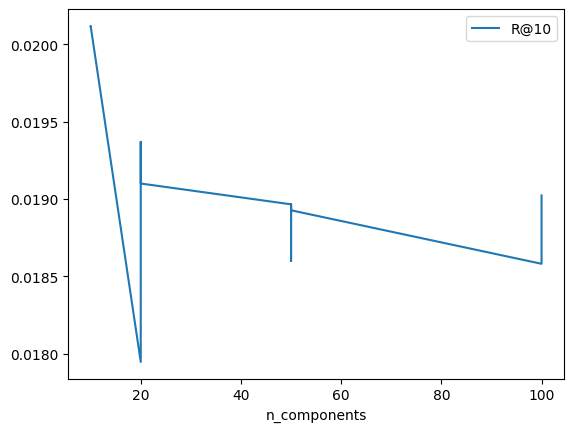

In [114]:
eval_scores_df.plot(x="n_components", y="R@10")

<Axes: xlabel='n_components'>

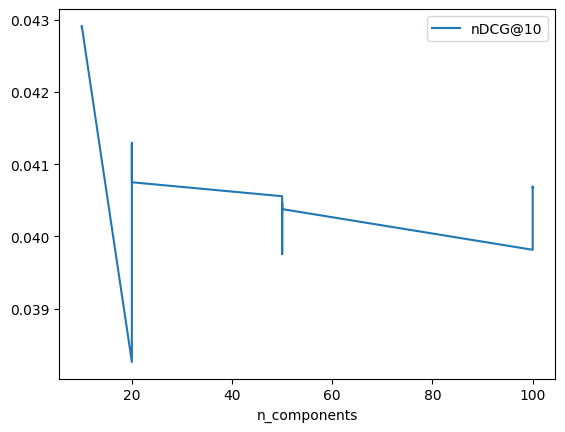

In [115]:
eval_scores_df.plot(x="n_components", y="nDCG@10")